In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from keras import models, layers
from tqdm import tqdm
import os
import gc
from textwrap import wrap
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [2]:
annotation_file = '../input/flickr-8k-caption/captions.csv'
captions = pd.read_csv(annotation_file, delimiter=',')
captions = captions.dropna(how='any')
captions = captions.reset_index(drop=True)
print(len(captions))

40455


In [3]:
captions.head(10)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [4]:
# let's add start and end tokens to each entry in the captions dataframe

START_TOKEN = '<start>'
END_TOKEN = '<end>'

def add_start_end(text):
    return START_TOKEN + str(text) + END_TOKEN

captions['caption'] = captions['caption'].apply(add_start_end) # there's a space in the column name

In [5]:
captions['caption'].values[:3]

array(['<start>A child in a pink dress is climbing up a set of stairs in an entry way .<end>',
       '<start>A girl going into a wooden building .<end>',
       '<start>A little girl climbing into a wooden playhouse .<end>'],
      dtype=object)

### Preprocessing the text data

In [6]:
target = captions['caption'].tolist()
target[:3]

['<start>A child in a pink dress is climbing up a set of stairs in an entry way .<end>',
 '<start>A girl going into a wooden building .<end>',
 '<start>A little girl climbing into a wooden playhouse .<end>']

In [7]:
# let's tokenize and pad the sequences to the same length
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

num_words = 30000
tokenizer = Tokenizer(num_words = num_words, filters='!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(target)

In [8]:
len_cap = np.array([len(text.split()) for text in target])
print(len_cap.mean(), len_cap.std(), len_cap.max(), len_cap.min())
max_seq_len = int(np.percentile(len_cap,99.9))
print(max_seq_len)

11.78259794833766 3.8851034918514062 38 1
29


In [9]:
target = tokenizer.texts_to_sequences(target)
target = pad_sequences(target, maxlen=max_seq_len, padding='post', truncating='post')

In [10]:
# sanity check
sample = tokenizer.sequences_to_texts(target[15:30])
sample

['start a man lays on a bench while his dog sits by him . end',
 'start a man lays on the bench to which a white dog is also tied . end',
 'start a man sleeping on a bench outside with a white and black dog sitting next to him . end',
 'start a shirtless man lies on a park bench with his dog . end',
 'start man laying on bench holding leash of dog sitting on ground end',
 'start a man in an orange hat starring at something . end',
 'start a man wears an orange hat and glasses . end',
 'start a man with gauges and glasses is wearing a blitz hat . end',
 'start a man with glasses is wearing a beer can crocheted hat . end',
 'start the man with pierced ears is wearing glasses and an orange hat . end',
 'start a child playing on a rope net . end',
 'start a little girl climbing on red roping . end',
 'start a little girl in pink climbs a rope bridge at the park . end',
 'start a small child grips onto the red ropes at the playground . end',
 'start the small child climbs on a red ropes on 

### Preprocessing the image data

In [15]:
# some image parameters
img_height = 256
img_width = 256
n_channels = 3

img_directory = '../input/flickr8k/Images/'

Since each image has 5 captions in the captions dataframe, we simply duplicate each image 5 times and then map each image to its caption in the dataframe.

In [16]:
# get the images

dataset_path = []

for i in range(len(captions)):
    full_path = img_directory + captions['image'].values[i]
    dataset_path.append(full_path)
    
print(dataset_path[0])
len(captions), len(dataset_path)

../input/flickr8k/Images/1000268201_693b08cb0e.jpg


(40455, 40455)

In [17]:
list(captions['caption'].values[:5])

['<start>A child in a pink dress is climbing up a set of stairs in an entry way .<end>',
 '<start>A girl going into a wooden building .<end>',
 '<start>A little girl climbing into a wooden playhouse .<end>',
 '<start>A little girl climbing the stairs to her playhouse .<end>',
 '<start>A little girl in a pink dress going into a wooden cabin .<end>']

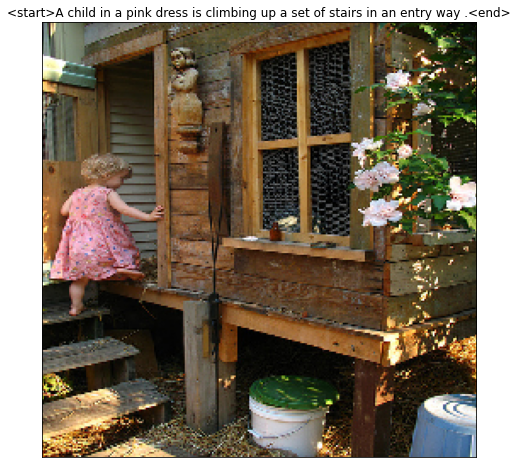

In [18]:
# let's visualize this
from tensorflow.keras.preprocessing.image import load_img, img_to_array

plt.figure(figsize=(10, 8))
plt.xticks([])
plt.yticks([])

img = load_img(dataset_path[0], target_size=(img_height, img_width))
caption = captions['caption'].values[0]
plt.title(caption)
plt.imshow(img)

In [19]:
temp_images = []
for i in range(1, 120, 5):
    temp_images.append(dataset_path[i])

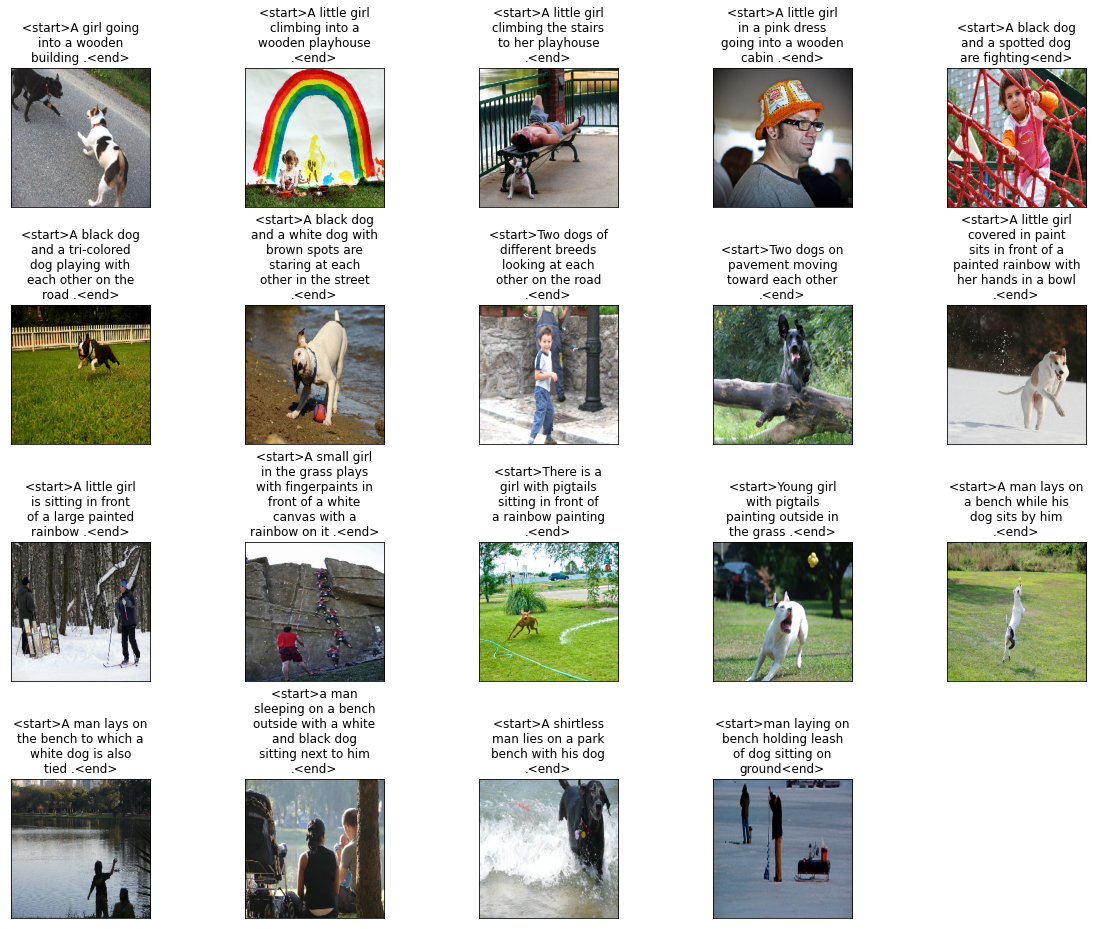

In [21]:
# plot pictures and their captions
plt.figure(figsize=(20, 20))
for i in range(1, 20):
    plt.subplot(5, 5, i)
    plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
    plt.xticks([])
    plt.yticks([])
    img = load_img(temp_images[i], target_size = (img_height, img_width))
    caption = captions['caption'].values[i]
    plt.title('\n'.join(wrap(caption, 20)))
    plt.imshow(img)

### Split dataset into train and validation set

Note that due to each image have 5 captions, we cannot splitting the data randomly. Here, to avoid knowledge leakage from train-set to valid-set, we must use GroupKFold to carefully make each image stays in the same set.

In [22]:
from sklearn.model_selection import GroupKFold

groups_kfold = GroupKFold(n_splits=40).split(X=dataset_path, groups=dataset_path)

for index, (train_index, val_index) in enumerate(groups_kfold):
    train_dataset = np.array(dataset_path)[train_index]
    val_dataset = np.array(dataset_path)[val_index]
    
    train_captions = target[train_index]
    val_captions = target[val_index]

In [23]:
len(train_dataset), len(val_dataset)

(39445, 1010)

In [24]:
len(train_captions), len(val_captions)

(39445, 1010)

### Feature Extraction with a Pretrained Model

We would be extracting features from the InceptionV3 pretrained model using imagenet's weights. The idea is to instantiate the model using the last Conv2D layer - without the Dense head - to extract the features from the images

In [25]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', 
                                                input_shape=(img_height, img_width, n_channels))

new_input = image_model.input
hidden_layer = image_model.layers[-1].output
print(hidden_layer.shape)

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

2022-08-25 20:45:15.495985: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 20:45:15.622171: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 20:45:15.622952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 20:45:15.624724: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 1s 0us/step
(None, 6, 6, 2048)


In [26]:
# use in Inference mode only
set_trainable = False

for layer in image_features_extract_model.layers:
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

### Using TF.Dataset for easy loading

In [27]:
train = tf.data.Dataset.from_tensor_slices((train_dataset, train_captions))
validation = tf.data.Dataset.from_tensor_slices((val_dataset, val_captions))

In [28]:
def decode_image(filename, captions):
    """Function to pass an image into a pretrained model and extract the features.
    
    Returns the features extracted and the corresponding captions
    """
    # read the image
    img = tf.io.read_file(filename)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(img_height, img_width)(img)
    img = img/255. 
    
    return img, captions


In [29]:
# map the decode_image function to the dataset
train = train.map(lambda item1, item2: tf.numpy_function(decode_image, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation = validation.map(lambda item1, item2: tf.numpy_function(decode_image, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [30]:
# TF DATA parameters
BATCH_SIZE = 64
BUFFER_SIZE = 1000

train = train.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE, drop_remainder=False).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation = validation.batch(BATCH_SIZE, drop_remainder=False).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [31]:
for i, (img_tensor, captions) in tqdm(enumerate(train)):
    print(img_tensor.shape)
    print(captions.shape)
    if i == 0: # to run only once
        break

0it [00:00, ?it/s]2022-08-25 20:45:26.204374: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
0it [00:06, ?it/s]

(64, 256, 256, 3)
(64, 29)


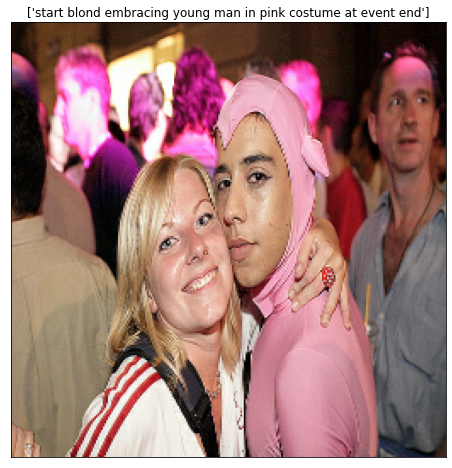

In [32]:
# let's load an image & its caption
img = img_tensor[0]
caption = captions[0]

plt.figure(figsize=(10, 8))
plt.xticks([])
plt.yticks([])
title = tokenizer.sequences_to_texts([np.array(caption).tolist()])
plt.title(title)
plt.imshow(img)

In [33]:
gc.collect()

734

## ML Model

In [34]:
# some parameters

embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index)
features_shape = 2048
attention_features = 6
attention_features_shape = attention_features**2

### Encoder

The encoder is simply a model which receives the features extracted from the dataset and then feeds it into a Dense layer and returns the output which would be fed to a decoder

In [35]:
class Encoder(tf.keras.Model):
    def __init__(self, embedding_dim, pretrained_model):
        super(Encoder, self).__init__()
        self.pretrained = pretrained_model
        self.fc = layers.Dense(embedding_dim)
        
    def __call__(self, x):
        x = self.pretrained(x) # returns shape (batch_size, 6, 6, 2048)
        x = tf.reshape(x, (x.shape[0], -1, x.shape[3])) # reshape to 3D
        x = self.fc(x)
        x = tf.nn.relu(x)
        
        return x #shape == (batch_size, attention_features_shape, embedding_dim)

In [36]:
# sanity check
img = img.reshape((1, img_height, img_width, n_channels))
encoder = Encoder(embedding_dim, image_features_extract_model)
output = encoder(img)

output

2022-08-25 20:45:57.571397: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


<tf.Tensor: shape=(1, 36, 256), dtype=float32, numpy=
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.30286825, 0.        ],
        [0.        , 0.46634817, 0.        , ..., 0.        ,
         0.54843974, 0.        ],
        [0.        , 0.29043388, 0.        , ..., 0.        ,
         1.354878  , 0.        ],
        ...,
        [1.0208236 , 0.7042518 , 0.        , ..., 0.15154105,
         2.0341282 , 0.        ],
        [0.21468115, 1.5047085 , 0.        , ..., 0.        ,
         2.1362517 , 0.        ],
        [0.        , 0.7966099 , 0.        , ..., 0.        ,
         2.0096076 , 0.        ]]], dtype=float32)>

### Decoder

In this implementation, we shall use LSTMs for the Decoder. The 

In [37]:
class Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.embedding = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=False)
        self.fc1 = layers.Dense(units)
        self.fc2 = layers.Dense(vocab_size)
        self.lstm = layers.LSTM(embedding_dim)
        self.dropout = layers.Dropout(0.5)
        
    def __call__(self, features, target, training=True):
        """Builds the decoder. The decoder accepts two tensor inputs - features and target.
        
        features refer to the output from the Encoder above
        target refer to the caption tensors
        """
        target = self.embedding(target) # make an embedding vector of the caption tensors
        features_target_merged = tf.concat([features, target], axis=1)
        features_target_merged = self.lstm(features_target_merged)
        features_target_merged = self.dropout(features_target_merged, training)
        features_target_merged = self.fc1(features_target_merged)
        features_target_merged = self.dropout(features_target_merged, training)
        
        features_target_merged = self.fc2(features_target_merged)
        return features_target_merged

### RNN DECODER

In [38]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        
        score = self.V(attention_hidden_layer)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights
    
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, 
                                       recurrent_initializer= 'glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        
        self.attention = BahdanauAttention(self.units)
        
    def call(self, x, features, hidden):
        # compute the attention score
        context_vector, attention_weights = self.attention(features, hidden)
        
        # compute embedding for the text tokens and concat with the context vector
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        output, state = self.gru(x) # a recurrent neural network
        
        x = self.fc1(output)
        
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        
        return x, state, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [39]:
# end to end test
img = img_tensor
captions = captions

encoder = Encoder(embedding_dim, image_features_extract_model)
decoder = Decoder(embedding_dim, units, vocab_size)

In [40]:
# the encoder
outputs = encoder(img)
outputs.shape

TensorShape([64, 36, 256])

In [41]:
# the decoder
features = outputs
target = captions
pred = decoder(features, target)
pred.shape

TensorShape([64, 8496])

### Training

In [42]:
pretrained_model = image_features_extract_model
encoder = Encoder(embedding_dim, pretrained_model)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
        
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
        
    loss = tf.reduce_mean(loss_)
    #loss_ = tf.nn.compute_average_loss(loss_, global_batch_size=BATCH_SIZE)
    #loss = tf.reduce_sum(loss_)/tf.reduce_sum(mask)
        
    return loss

In [43]:
# for train dataset
@tf.function
def train_step(img_tensor, target):
    loss = 0
        
    hidden = decoder.reset_state(batch_size=target.shape[0]) # ???
    dec_input = tf.expand_dims([tokenizer.word_index['start']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        
        for i in range(target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1) # use teacher forcing
                
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
        
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss

In [ ]:
import time
start_epoch = 0
EPOCHS = 20
num_steps = len(train) // (BATCH_SIZE)
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    for (batch, (img_tensor, target)) in enumerate(train):
        loss = train_step(img_tensor, target)
        
        if batch % 50 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {loss:.4f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 125.9492
Epoch 1 Batch 50 Loss 75.4435
Epoch 1 Batch 100 Loss 58.7115
Epoch 1 Batch 150 Loss 53.5268
Epoch 1 Batch 200 Loss 52.1913
Epoch 1 Batch 250 Loss 50.1369
Epoch 1 Batch 300 Loss 50.0888
Epoch 1 Batch 350 Loss 46.7062
Epoch 1 Batch 400 Loss 44.9529
Epoch 1 Batch 450 Loss 45.9984
Epoch 1 Batch 500 Loss 44.3887
Epoch 1 Batch 550 Loss 45.8305
Epoch 1 Batch 600 Loss 44.5619
Time taken for 1 epoch 399.91 sec

Epoch 2 Batch 0 Loss nan
Epoch 2 Batch 50 Loss nan


## Evaluate

In [ ]:
max_length = 20

In [42]:
def _evaluate(image_tensor):
    """Lower-level nonpublic function to predict the caption for a given image input"""
    hidden = decoder.reset_state(batch_size=1) # predicting for only 1 image
    
    # reshape image tensor to expected shape by the encoder and pass to the encoder
    image_tensor = image_tensor.reshape((1, img_height, img_width, n_channels))
    features = encoder(image_tensor)
    
    dec_input = tf.expand_dims([tokenizer.word_index['start']], 0)
    results = []
    
    for i in range(max_length):
        predictions, _, _ = decoder(dec_input, features, hidden)
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        #print(predicted_id)
        predicted_word = tf.compat.as_text(tokenizer.index_word[predicted_id])
        
        results.append(predicted_word)
        
        if predicted_word == '<end>':
            return results
        
        # update the decoder & move to the next token
        dec_input = tf.expand_dims([predicted_id], 0)
        
        return results

In [43]:
def caption(image_path):
    """Function to preprocess an image for captioning and then runs the trained model for inference
    Relies on lower level _evaluate function for inference
    
    """
    
    img = load_img(image_path, target_size=(img_height, img_width))
    img = np.array(img)
    result = _evaluate(img)
    
    # plot the image
    plt.figure(figsize=(10, 8))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.title(' '.join(result))

In [44]:
image_path = '../input/flickr-image-dataset/flickr30k_images/flickr30k_images/1000092795.jpg'
caption(image_path)

KeyError: 0